In [2]:
words = open('names.txt', 'r').read().splitlines()

### Create trigrams where first two characters are inputs and the following character is the output.

In [123]:
import torch
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
xs = []
ys = []

for w in words[:1]: 
    chs = ['.'] + list(w) + ['.']  # Add padding character at start and end
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append([ix1, ix2])  # Store the first two characters as input
        ys.append(ix3)  # Store the third character as the target

# Convert lists to tensors
xs = torch.tensor(xs)  # Shape will be (number of trigrams, 2)
ys = torch.tensor(ys)  # Shape will be (number of trigrams,)

In [6]:
xs, ys

(tensor([[ 0,  5],
         [ 5, 13],
         [13, 13],
         [13,  1]]),
 tensor([13, 13,  1,  0]))

#### Now we have inputs, which indicates two characters. 
We cannot feed these inputs directly to a neural net since these are integers. Let's <b>one hot</b> encode them to get one hot encoded vectors of these inputs. 

In [7]:
xs.shape

torch.Size([4, 2])

In [9]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc.shape

torch.Size([4, 2, 27])

4 indicates the batch dimension. It shows how many inputs are there in the batch. So there are 4 inputs, representing 4 trigrams that got created from the first word 'emma'.
That means, each input now is a 2D vector, since there are two characters now. 
The shape of the 2D vector is [2, 27], where 2 represents the number of characters (which is 2) and 27 represents the one hot encoded representation of the input. 27 means that there are 27 possible characters, out of which only one character will be 1, rest will be zero. 

Let's examine 1 input.

In [14]:
xenc.shape, xenc[0]

(torch.Size([4, 2, 27]),
 tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

### If a single input is now a 2D vector, how do we feed it to the neurons? 
In th bigram example, our input was a 1D [1, 27] vector, which we could directly feed to the model. 
But here, we have a [2, 27] shape vector.

### One way to do this is that we convert this [2, 27] vector into a [1, 54] vector by concatenating the 2 rows into 1 row. This operation is called flattening the vector.
There are other ways as well, but first let's try this approach. 

In [29]:
xsingle = xenc[0]
xsingle.shape

torch.Size([2, 27])

In [21]:
xsingle_flat = xsingle.view(-1)
xsingle_flat.shape

torch.Size([54])

Now we have 1D vector of  length 54. 

Let's convert the entire batch of inputs. xenc has the shape of [4, 2, 27]. Where 4 signifies the number of inputs in the batch (meaning, we have 4 inputs, each expecting its next character). So while flattening, we want to flatten each of these 4 inputs separately, so that we have 4 inputs of 1D vectors of length 54. 

Hence, the expected shape will be [4, 54].
This indicates that each input has 54 features now.

In [25]:
xenc_f = xenc.view(4, -1)

In [26]:
xenc_f.shape

torch.Size([4, 54])

Now that our input is ready, let's think about the layer, starting with a single neuron.

### How many weights will a neuron have?
Since, the input has 54 features, we will need 54 weights per neuron, so that each feature can influence the output of a neuron with a specific weight. 
The linear transformation of the neuron will look something like this:
</br>

output of neuron = w1x2 + w2x2 + w3x3 + ....... w54x54

Let's define a weight matrix, for a single neuron to begin with, of shape [54, 1].

<b>Another important thing to note here, why do we define the weight matrix of shape [54, 1] and not [1, 54]? In other words, why is it a column matrix and not a row matrix? </b>

If we check our single input, it is of shape [1, 54], it is a row matrix. Our goal is to multiple the input vector with the weight vector, to obtain a single output of this neuron. It should be of the shape [1, 1]. That is only possible if the input matrix is a row matrix [1, 54] and the weights are a column matrix [54, 1]. The result of this multiplication will be a matrix of [1, 1].
We want to add all the multiplicatives of xiwi, which is essentially a matrix multiplication. 


In [33]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54, 1), generator = g, requires_grad=True)

W.shape

torch.Size([54, 1])

This ofcourse is a single neuron. Each weight in the column influences one feature of the input each. It defines how much will each feature  affect the output of the neuron. 
This matrix multipliacation that we are performing is nothing but the <b>Forward Pass</b> (barring loss calculation at the moment).

In [36]:
out = (xenc_f @ W)
out.shape

torch.Size([4, 1])

In [37]:
out

tensor([[ 1.6185],
        [-0.5326],
        [-0.9359],
        [-1.6529]], grad_fn=<MmBackward0>)

Since our input has a batch size of 4, we get a [4, 1] vector, which is a column vector. each value is the output of this neuron for each input in the batch. 

### Let's build a layer with 27 neurons. Why do we need 27 neurons? 
Since we want to predict the next character, and there are 27 possible characters. Hence, each neuron will give us the probability (logit at the moment) of one character. From these 27 neurons, we will have the probability (logits) of all 27 possible characters, given an input.

### What will be the shape of this weights matrix now?
Well, each neuron is a column vector and we have 27 such neurons, so the shape will be [54, 27], signiying 27 neurons with each having 54 weights.

In [38]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54, 27), generator = g, requires_grad=True)
W.shape

torch.Size([54, 27])

### Let's understand the output vector shapes
Let's take a single input (batch size 1) and see what that yields. Let's first understand that manually. </br>
We have an input vector of shape [1, 54] and a weights vector of shape [54, 27]. Multiplying these vectors will give us an output vector of shape [1, 27]. 
### What does this shape signify?
It signifies that we will have a 1D vector of 27 outputs. These represent the logits of 27 neurons. In other words, it represents the probabilities of each out of the 27 possible characters as the next character in the sequence. 

If input is [e, m], the 27 outputs signify the probabilities of what the third character can be. Let's call output as the output vector of shape [1, 27], then <br>
output[0][0] will signify the probability of '.' character to be next character ('.' has index 0, 'a' has index 1...) and so on. 

One question might be, if output is a 1D vector, why do we have the shape as [1, 27]? Well, [1, 27] is just torch's way of maintaining the batch dimension. [1, 27] is same as [27] shape 1D vector, expect you need [0] as row value to actually access the 27 outputs.

In [107]:
xsingle = xenc_f[0].unsqueeze(0)
xsingle.shape

torch.Size([1, 54])

xsingle is our single input (batch size is 1). 

In [108]:
output = xsingle @ W
output.shape

torch.Size([1, 27])

In [109]:
output

tensor([[ 0.5352,  0.2418, -0.2616, -1.0364,  0.4752, -0.3721, -0.2249, -0.4349,
         -0.6773,  1.1168,  1.6238,  1.3033,  0.3456,  0.5469,  2.9616,  1.7805,
          0.8366, -0.8746,  2.0334,  0.3803,  0.6542, -0.8347, -1.6931,  1.4028,
         -1.6675,  0.6432,  1.0764]], grad_fn=<MmBackward0>)

Given the input as '.', 'e'; let's check for the probability of 'm' character to be next character is (since .e is followed by m in the trigram). Index of m can be found out from stoi dictionary created above. 

In [110]:
index_m = stoi['m'] # it is 13
output[0][index_m]

tensor(0.5469, grad_fn=<SelectBackward0>)

Remember, these probabilities (logits) are just random values that the layer is outputting since we used random weights.
</br>Also, these values in output are not actually probabilities, as you can see above that these values are negative as well and also some are greater than 1. These are just neurons' outputs after linear transformation (Σ(xiwi)). 

We need to perform 2 operations in order to make them probabilities. 
1. <b>Exponentiation</b>:
   This step converts the negative values to positive. Why not just take absolute value? Well, exp also scales the values such that the greater values stand out more. Let's say a = 2 and b = 4. |a| = 2 and |b| = 4. The difference between these values remain the same.
   But taking exp(a) = 7.39 and exp(b) = 54.6. You can see that the difference after exponentiation increases, thus making greater values stand out more.
2. <b>Normalization</b>:
   The outputs are now positive but they are still not probabilities. In order to make them probabilities, we normalise them with the sum of all the outputs for a given input.
</br>
<b>These 2 steps collectively make Softmax Function.</b></br>

$$
\text{softmax}(z_i) = \frac{\exp(z_i)}{\sum_{j=1}^{n} \exp(z_j)}
$$

Let's convert these outputs to probabilities. 

In [111]:
output

tensor([[ 0.5352,  0.2418, -0.2616, -1.0364,  0.4752, -0.3721, -0.2249, -0.4349,
         -0.6773,  1.1168,  1.6238,  1.3033,  0.3456,  0.5469,  2.9616,  1.7805,
          0.8366, -0.8746,  2.0334,  0.3803,  0.6542, -0.8347, -1.6931,  1.4028,
         -1.6675,  0.6432,  1.0764]], grad_fn=<MmBackward0>)

In [112]:
probs = torch.exp(output)/ output.exp().sum(1, keepdim=True)
probs

tensor([[0.0237, 0.0177, 0.0107, 0.0049, 0.0223, 0.0096, 0.0111, 0.0090, 0.0071,
         0.0424, 0.0704, 0.0511, 0.0196, 0.0240, 0.2683, 0.0824, 0.0320, 0.0058,
         0.1061, 0.0203, 0.0267, 0.0060, 0.0026, 0.0565, 0.0026, 0.0264, 0.0407]],
       grad_fn=<DivBackward0>)

Now they are actually probabilities.

In [113]:
index_m = stoi['m'] # it is 13
probs[0][index_m]

tensor(0.0240, grad_fn=<SelectBackward0>)

So the probability of 'm' being the next character with input '.e', is 0.02. Not very good. We will improve this by training the model at a later stage. 

This also defines the <i>Likelyhood</i> of the next character to be 'm'. Right now, we only have 1 input. <br>
If we had multiple inputs, we won't be able to indivisually use these probabilities to compute the performance of the model. 

We would want a single value to access the performance of the model. 
One way to get that single value is multiplying the probabilities of expected next characters for each input. 
Let's say, 
<br>input 1 expects character 'm' to be the next character. Its probability is p1.
<br>input 2 expects character 'a' to be the next character. Its probability is p2.

The overall probability will be p = p1 * p2. 

Since, probabilities range between 0 to 1, after multitplying, this value becomes very small. How to deal with that?
Let's discuss the issues with working with very small probability values first. 

1. <b>Underflow issues</b>: Very small values can easily underflow since the datatypes in computers have a certain precision.
2. <b>Loss of gradients of vanishing gradients</b>: Working with very small values generate very small gradients during backpropogation, effectively almost losing the gradients. With neglegible gradients, we will not be able to modify the weights to achieve correct weight values. This problem is called <b>vanishing gradient issue</b>.

<b>How do we fix this?</b>
The problem is the multiplication that makes the values very small. What if we did not have to multiply at all?
<b>Logarithms</> to the rescue.
We know that 
$$
log(p1*p2) = log(p1) + log(p2)
$$

Hence, taking logs of probabilities help us get rid of very small values. 


In [114]:
prob_m = probs[0][index_m]
prob_m

tensor(0.0240, grad_fn=<SelectBackward0>)

In [115]:
log_prob = torch.log(prob_m)
log_prob

tensor(-3.7302, grad_fn=<LogBackward0>)

In order to gauge the performance and improve the performance of the model, we would need to increase this log_probability value. 
Another way to look at it, is, if I negate this value, it becomes a value that my model should reduce. This is called <b>Loss</b>.
More specifically, this is known as the <b>Negative Likelyhood Log</b> loss, since we took log of the <i>likelyhood</i> of a character and the negated it. 
$$
NLL = -(log(probability))
$$
This is ofcourse just for 1 input. For multiple inputs, we sum the log probabilities of outputs and then negate the sum.

In [117]:
nll = -log_prob
nll

tensor(3.7302, grad_fn=<NegBackward0>)

This is the value we will try to reduce using gradient descent.
But before that, let's attempt to use all the inputs instead of just a single input and try to figure out the shape of the output matrix.

Our input xenc_f is of shape [4, 54] signifying 4 inputs (batch size) with 54 features each. 
Our weights are [54, 27] signifying 27 neurons with 54 weights per neuron.

The multiplication (xenc_f @ W) of these vectors will yield an output of [4, 27] shape. 
It must be clear by now, that this represents the 27 logits, one for each character and 4 such vectors, one for each input. 

In [118]:
output = xenc_f @ W
output.shape

torch.Size([4, 27])

In [119]:
probs = torch.exp(output) / torch.exp(output).sum(1, keepdim=True)
probs

tensor([[0.0237, 0.0177, 0.0107, 0.0049, 0.0223, 0.0096, 0.0111, 0.0090, 0.0071,
         0.0424, 0.0704, 0.0511, 0.0196, 0.0240, 0.2683, 0.0824, 0.0320, 0.0058,
         0.1061, 0.0203, 0.0267, 0.0060, 0.0026, 0.0565, 0.0026, 0.0264, 0.0407],
        [0.0224, 0.0482, 0.0110, 0.0675, 0.0691, 0.0033, 0.0108, 0.0058, 0.0093,
         0.0043, 0.1095, 0.0867, 0.0058, 0.0074, 0.0009, 0.0084, 0.0135, 0.0044,
         0.0651, 0.0046, 0.0327, 0.0632, 0.0720, 0.0006, 0.0040, 0.0079, 0.2616],
        [0.0226, 0.0417, 0.0201, 0.0403, 0.0219, 0.0021, 0.0284, 0.0040, 0.1099,
         0.0022, 0.0109, 0.2800, 0.0062, 0.0102, 0.0011, 0.0028, 0.0253, 0.0110,
         0.0432, 0.0012, 0.0131, 0.0155, 0.0178, 0.0045, 0.0386, 0.1600, 0.0655],
        [0.0104, 0.0781, 0.1008, 0.0187, 0.1996, 0.0441, 0.0178, 0.0055, 0.1757,
         0.0179, 0.0007, 0.0651, 0.0027, 0.0142, 0.0122, 0.0315, 0.0151, 0.0067,
         0.0196, 0.0006, 0.0230, 0.0011, 0.0198, 0.0236, 0.0645, 0.0272, 0.0040]],
       grad_fn=<DivBack

Let's compute overall loss, knowing what the expected character is for each input, from ys. 

In [120]:
ys

tensor([13, 13,  1,  0])

In [121]:
probs[torch.arange(4), ys]

tensor([0.0240, 0.0074, 0.0417, 0.0104], grad_fn=<IndexBackward0>)

These are the probabilities of the characters which are actually expected as the next character, for each input.
Let's compute negative likelyhood loss from these. 

In [122]:
nll = -probs[torch.arange(4), ys].log().mean()
nll

tensor(4.0953, grad_fn=<NegBackward0>)

This nll is what we would attempt to reduce.
We will do this with gradient descent.

Let's take the entire dataset instead of just 1st word.


In [213]:
xs = []
ys = []

for w in words: 
    chs = ['.'] + list(w) + ['.']  # Add padding character at start and end
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append([ix1, ix2])  # Store the first two characters as input
        ys.append(ix3)  # Store the third character as the target

# Convert lists to tensors
xs = torch.tensor(xs)  # Shape will be (number of trigrams, 2)
ys = torch.tensor(ys)  # Shape will be (number of trigrams,)

nums = len(xs)

# One hot encode the inputs
xenc = F.one_hot(xs, num_classes=27).float()

# Flatten the inputs 
xenc_f = xenc.view(nums, -1)

# Define weights 
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54, 27), generator = g, requires_grad=True)

In [214]:
h = 1
for k in range(1000):
    # Forward pass 
    output = xenc_f @ W 
    
    # Softmax function
    probs = output.exp() / output.exp().sum(1, keepdim=True)

    loss = -probs[torch.arange(nums), ys].log().mean() # Taking mean instead of sum, just to normalise the nll value. Can take .sum as well.

    # Zero grad 
    W.grad = None 

    # Back propogation to generate grads of weights
    loss.backward() 

    # Update the weights based on the backprop 
    W.data += -h * W.grad
    if k % 100 == 0:
        print(f"Loss: {loss}")

Loss: 4.186270713806152
Loss: 3.0845019817352295
Loss: 2.7903473377227783
Loss: 2.6534831523895264
Loss: 2.569455862045288
Loss: 2.512267589569092
Loss: 2.4712893962860107
Loss: 2.4407241344451904
Loss: 2.417064666748047
Loss: 2.3981637954711914


We brought down the loss from around 4 to 2.4. Let's do some predictions on this! 

In [216]:
def generate_word(model, stoi, itos, start_letter, max_length=7):
    if start_letter not in stoi:
        raise ValueError(f"Starting letter '{start_letter}' not found in vocabulary.")
    
    generated_word = [start_letter]
    ch1 = start_letter
    ch2 = '.'  
    
    for _ in range(max_length - 1):
        # Convert characters to indices
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        
        x_input = F.one_hot(torch.tensor([ix1, ix2]), num_classes=27).float().view(1, -1)  # Shape: [1, 54]
        
        output = x_input @ W
        
        probs = output.exp() / output.exp().sum(1, keepdim=True)
        
        ix3 = torch.multinomial(probs, num_samples=1).item()  # Randomly sample based on predicted probabilities
        
        ch3 = itos[ix3]
        
        if ch3 == '.':
            break
        
        generated_word.append(ch3)
        
        ch1, ch2 = ch2, ch3  # Shift characters for the next prediction

    return ''.join(generated_word)

start_letter = 'p'
for _ in range(5):
    word = generate_word(W, stoi, itos, start_letter)
    print("Generated word:", word)


Generated word: pceraha
Generated word: prayn
Generated word: pcer
Generated word: pyahan
Generated word: pjenan


### torch.multinomial(probs, num_samples=1).item()

It samples an index based on the probability distribution in probs. This allows for some randomness, meaning it’s more likely to pick indices with higher probabilities, but it doesn't guarantee that it will pick the one with the highest probability.

Here’s what happens in detail:
<br>
Sampling with Probabilities: torch.multinomial samples from the distribution provided by probs, where each index has a probability of being selected proportional to its value. Indices with higher probabilities have a higher chance of being picked, but it’s not deterministic.

<b>Our loss is still ~2.4</b>. 

## Understanding the role of bias, mathematically!
### We will attempt to improve the loss, but first, let's understand the math behind the bias.
#### Let's closely look at the linear transformation of each neuron more closely. Let's consider only 1 input of 2 features, [x1, x2]
output of a neuron is given by:
$$
    neuron linear transformation = x1w1 + x2w2
$$
This represents a line in a 2 dimentional space, resembling <b><i>y = mx + c</i></b>, where c is 0.
<br>Let's set w1 = 1 & w2 = 2 

The line equation becomes, 

$$
   neuron linear transformation = x1 + 2(x2)
$$

The decision boundary of the neuron is simply the line where y = 0. 
Let's find that out. 

$$
    x1 + 2(x2) = 0
$$
$$
    x2 = -(1/2)x1
$$

<b>m or the slope of the line becomes</b>
$$
    m = -(w1/w2)
$$

Comparing with y = mx + c, where c is 0, m or the slope of the line becomes -(1/2). Let's plot this line. 

In [174]:
# w1 = 1 & w2 = 2

y = [-0.5 * x1 for x1 in range(1, 10)]
y

[-0.5, -1.0, -1.5, -2.0, -2.5, -3.0, -3.5, -4.0, -4.5]

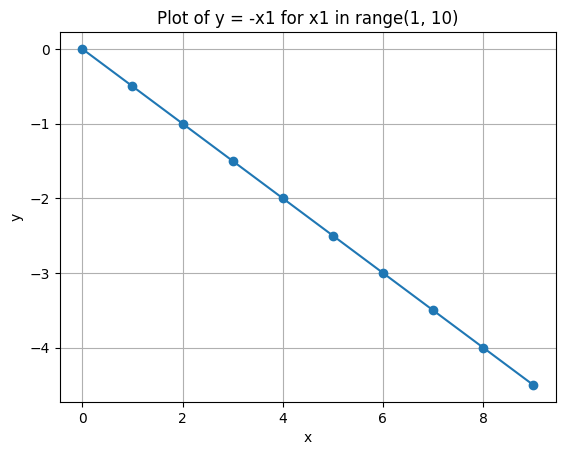

In [179]:
import matplotlib.pyplot as plt
%matplotlib inline

x1 = list(range(0, 10))
y = [-0.5 * x for x in x1]

# Plotting
plt.plot(x1, y, marker='o')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of y = -x1 for x1 in range(1, 10)')
plt.grid(True)
plt.show()

This line above for the neuron, is known as the <b>Decision Boundary</b> of the neuron. 
Above this boundary, for any value of x, the output of neuron is 'active' and below is 'inactive' (y > 0, y <= 0).

Let's see what happens when the model gets trained and the weights get updated. 
Let's change the values of w1 = 2 and w2 = 1

The equation now becomes: 
$$
    y = -2(x1)
$$

Let's plot this

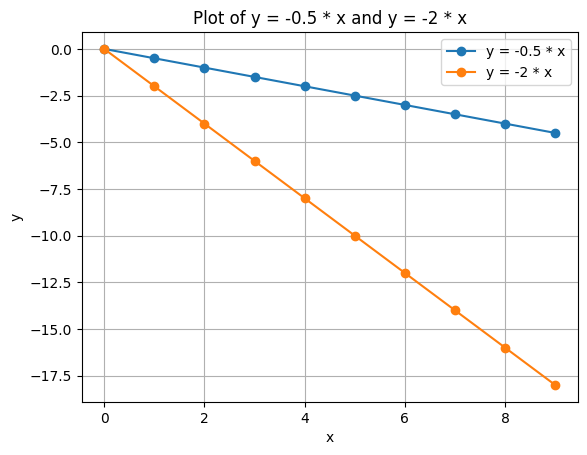

In [185]:
# Define x1 values
x1 = list(range(0, 10))

# Compute y values for both lines
y1 = [-0.5 * x for x in x1]
y2 = [-2 * x for x in x1]

# Plotting both lines
plt.plot(x1, y1, marker='o', label='y = -0.5 * x')
plt.plot(x1, y2, marker='o', label='y = -2 * x')

# Labels, title, and grid
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of y = -0.5 * x and y = -2 * x')
plt.legend()
plt.grid(True)

plt.show()


As can be seen in above figure, changing the weights is only changing the slope of the line, and not really the position of the line.
This 'position' of the line is known as the <b><i>intercept</i></b> of the line. Intercept is the point at which the line intersects the y axis.

When we train the model, the weights are always influenced by the inputs (because of the multiplication of xi and wi). When the model learns, it essentially moves this decision boundary line in such a way, that it can correctly classify and given point (given point lies above or below the decision boundary).

Let's assume a point (4, -7.5), and consider the weights w1 = 2, w2 = 1 (orange line above). 
Right now, the point lies above this decision boundary, hence the model is classifying this point as 'active'. 

Let's assume the expected classification of this point is 'inactive'.


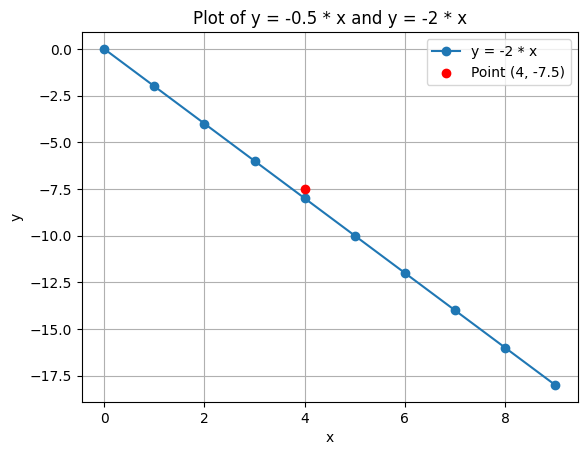

In [187]:
# Define x1 values
x1 = list(range(0, 10))

y2 = [-2 * x for x in x1]


plt.plot(x1, y2, marker='o', label='y = -2 * x')
plt.scatter(4, -7.5, color='red', label='Point (4, -7.5)', zorder=5)
# Labels, title, and grid
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of y = -0.5 * x and y = -2 * x')
plt.legend()
plt.grid(True)

plt.show()

The slope of the line is -2. -w1/w2 = -2.
$$
    slope = -w1 / w2 = -2
$$
The model will try to adjust its weights such that the point lies below the decision boundary. 

But another way to classify this point as 'inactive' (bring this point below the line), we can simply move the exact line slightly above, thus not changing the slope of the line. 

#### What will that do?
The current line intercepts the y axis at 0, which slope = -2. 
Saying simply moving the line above without changing the slope, essentially means that we make the line intercept y axis at a value > 0.
This will keep the slope of the line same. 

This is known as the <i>Intercept</i> of the line and is defined by <i>c</i> in the expression, <i>y = mx + c</i>.

#### What does it mean in terms of our neuron?
In our neuron linear transformation, this intercept is defined as <b><i>bias</i><b>. It is a constant value. 

Since the weights are dependent on the inputs (as seen above due to multitplication), they can only move so far. The constant <b><i>bias</i><b> gives the neuron a certain <i>degree of freedom</i>, which is not dependent on the inputs, so that the nueron can move its decision boundary more freely, thus learning the patterns better. 

Let's add a bias of 2 to the above orange line and see how it classifies the point now.

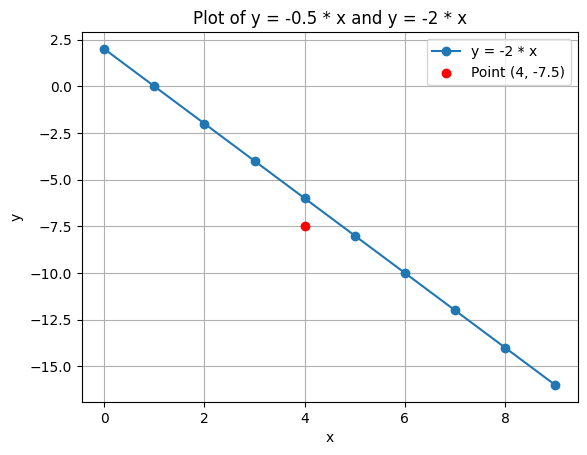

In [189]:
# Adding a constant to y = mx + c

x1 = list(range(0, 10))
b = 2 # This is c in line equation
y2 = [(-2 * x) + b for x in x1] # (m = -2, x is varying from 0 to 10 and c = 2)


plt.plot(x1, y2, marker='o', label='y = -2 * x')
plt.scatter(4, -7.5, color='red', label='Point (4, -7.5)', zorder=5)
# Labels, title, and grid
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of y = -0.5 * x and y = -2 * x')
plt.legend()
plt.grid(True)

plt.show()

After adding the constant bias of 2, we can see the neuron was able to classify the point (4, -7.5) as 'inactive', without changing the slope of the decision boundary at all.

#### Let's apply a bias to our neurons and see if it can improve the performance (reduce the loss even more)

In [199]:
b = torch.randn(27, generator=g, requires_grad=True)

In [194]:
b.shape

torch.Size([27])

The shape of the bias is 1D vector of 27 length. Values in this vector represent biases for 27 neurons. 
This bias will get added to the output. 
This makes the entire transformation of the neuron to be: 
$$
    output = Σ(wixi) + b
$$

Also, we want the biases to be updated as well. Hence the requires_grad for the bias is also true

In [210]:
xs = []
ys = []

for w in words: 
    chs = ['.'] + list(w) + ['.']  # Add padding character at start and end
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        xs.append([ix1, ix2])  # Store the first two characters as input
        ys.append(ix3)  # Store the third character as the target

# Convert lists to tensors
xs = torch.tensor(xs)  # Shape will be (number of trigrams, 2)
ys = torch.tensor(ys)  # Shape will be (number of trigrams,)

nums = len(xs)

# One hot encode the inputs
xenc = F.one_hot(xs, num_classes=27).float()

# Flatten the inputs 
xenc_f = xenc.view(nums, -1)

# Define weights Define bias 
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((54, 27), generator = g, requires_grad=True)
b = torch.randn(27, generator=g, requires_grad=True)

In [218]:
h = 1
for k in range(1000):
    # Forward pass 
    output = ( xenc_f @ W ) + b
    
    # Softmax function
    probs = output.exp() / output.exp().sum(1, keepdim=True)

    loss = -probs[torch.arange(nums), ys].log().mean() # Taking mean instead of sum, just to normalise the nll value. Can take .sum as well.

    # Zero grad 
    W.grad = None
    b.grad = None

    # Back propogation to generate grads of weights
    loss.backward() 

    # Update the weights and th bias based on the backprop 
    W.data += -h * W.grad
    b.data += -h * b.grad
    if k % 100 == 0:
        print(f"Loss: {loss}")

Loss: 2.298389196395874
Loss: 2.295156478881836
Loss: 2.292229413986206
Loss: 2.2895660400390625
Loss: 2.2871315479278564
Loss: 2.284897565841675
Loss: 2.2828404903411865
Loss: 2.280940055847168
Loss: 2.279179573059082
Loss: 2.277543544769287


Comparing the losses from the model with no bias, we can see that we were able to bring down the loss from 2.4 to 2.35.
This might seem insignificant but when layers are stacked, this makes a huge difference. 